In [1]:
%reset
%env HSA_OVERRIDE_GFX_VERSION=10.3.0

env: HSA_OVERRIDE_GFX_VERSION=10.3.0


In [2]:
import os
import warnings

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchinfo import summary
from Classes import StockData, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta

warnings.filterwarnings("ignore", category=UserWarning)

RawStockDataDirectory = 'Data/Raw/Stock'
ProcessedStockDataDirectory = 'Data/Processed/'
DatasetsDirectory = 'Data/Datasets/Stock_100'

inputLength = 90
outputLength = 14

In [3]:
torch.cuda.is_available()
device = torch.device('cuda')

In [4]:
model = LSTM(22,256,5,14)
model.load_state_dict(torch.load('Models/I(90,22)_O(14,1)_256HS_5L_256B/test01.pt'))
model.to(device)
model.eval()

LSTM(
  (lstm): LSTM(22, 256, num_layers=5, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=14, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [5]:
data = pd.read_csv('Data/Raw/Stock/NVDA', usecols=[1,2,3,4,5])

In [6]:
# Calculate moving averages
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA100'] = data['Close'].rolling(window=100).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

# Calculate RSI
data['RSI'] = ta.momentum.rsi(data['Close'], window=14)

# Calculate Bollinger Bands
BB = ta.volatility.BollingerBands(data['Close'])
data['BBup'], data['BBmid'], data['BBlow'] = BB.bollinger_hband(), BB.bollinger_mavg(), BB.bollinger_lband()

# Calculate MACD
MACD = ta.trend.MACD(data['Close'])
data['MACD'], data['MACDsig'], data['MACDdiff'] = MACD.macd(), MACD.macd_signal(), MACD.macd_diff()

# Calculate ROC
data['ROC'] = ta.momentum.ROCIndicator(data['Close']).roc()

# Calculate KAMA
data['KAMA'] = ta.momentum.kama(data['Close'])

# Calculate OBV
data['OBX'] = ta.volume.OnBalanceVolumeIndicator(close=data['Close'], volume=data['Volume']).on_balance_volume()

# Calculate STOCH
STOCH = ta.momentum.StochasticOscillator(close=data['Close'], high=data['High'], low=data['Low'])
data['STOCH'] = STOCH.stoch()
data['STOCHsig'] = STOCH.stoch_signal()

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [7]:
data

,Open,High,Low,Close,Volume,MA10,MA20,MA50,MA100,MA200,...,BBmid,BBlow,MACD,MACDsig,MACDdiff,ROC,KAMA,OBX,STOCH,STOCHsig
0,0.530485,0.572303,0.530485,0.557965,126033600,0.446970,0.428630,0.440769,0.415583,0.392329,...,0.428630,0.338104,0.020395,0.003349,0.017046,50.160738,0.449806,1057166400,93.103462,94.484927
1,0.573498,0.578277,0.513759,0.540044,61636800,0.459754,0.433170,0.442155,0.417638,0.393148,...,0.433170,0.330651,0.025454,0.007770,0.017685,40.372668,0.460157,995529600,82.123196,89.213482
2,0.523317,0.571108,0.506589,0.555576,47001600,0.476123,0.439084,0.443326,0.419944,0.393847,...,0.439084,0.323483,0.030368,0.012289,0.018078,37.982234,0.477120,1042531200,89.017496,88.081384
3,0.554381,0.556771,0.525706,0.547212,27235200,0.487832,0.444879,0.444365,0.422286,0.394665,...,0.444879,0.320157,0.033204,0.016472,0.016731,32.753480,0.485754,1015296000,84.883686,85.341459
4,0.549004,0.549602,0.531680,0.542433,14404800,0.500974,0.451032,0.444461,0.424412,0.395466,...,0.451032,0.319970,0.034666,0.020111,0.014555,38.414750,0.495094,1000891200,81.012758,84.971313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5916,288.959991,289.500000,282.459991,285.779999,32214900,284.097998,277.572000,265.389396,226.709130,188.803277,...,277.572000,261.353605,6.524162,6.242398,0.281764,8.905909,275.707983,16737231300,78.564238,81.903134
5917,285.290009,287.799988,280.459991,283.399994,27402700,284.688998,278.363000,266.395388,227.886311,189.331419,...,278.363000,262.635361,6.120837,6.218086,-0.097248,5.134292,275.835564,16709828600,70.617647,79.332187
5918,285.079987,289.690002,281.519989,289.529999,29392600,284.731998,279.338501,267.408800,229.156487,189.880519,...,279.338501,263.383206,6.224093,6.219287,0.004806,6.343197,275.902105,16739221200,89.710936,79.630940
5919,288.410004,298.700012,288.320007,292.130005,44940500,285.734998,280.111501,268.541400,230.469561,190.433675,...,280.111501,263.274587,6.441469,6.263723,0.177745,5.275871,276.533703,16784161700,79.753452,80.027345


In [8]:
dataset = StockData(data)
dataloader = DataLoader(dataset,shuffle=False, drop_last=False)

In [9]:
predictions = []
actual = []

In [10]:
for i, (x,y) in enumerate(dataloader):
    if i == 0:
        actual.append(x.float().numpy().reshape(90,22)[:,3])

        for nan in range(inputLength):
            predictions.append(np.array([[np.nan]]))

        x = x.float().to(device)
        with torch.no_grad():
            modelPrediction = model(x)

        predictions.append(modelPrediction.cpu().numpy().reshape(14,1))

        continue

    if (i-14) % 90 == 0:
        for nan in range(inputLength - outputLength):
            predictions.append(np.array([[np.nan]]))

        x = x.float().to(device)
        with torch.no_grad():
            modelPrediction = model(x)

        predictions.append(modelPrediction.cpu().numpy().reshape(14,1))

    if i % 90 == 0:
        actual.append(x.float().numpy().reshape(90,22)[:,3])

In [11]:
actual = np.concatenate(actual).reshape(-1,1)
predictions = np.concatenate(predictions).reshape(-1,1)

actual = dataset.outputScaler.inverse_transform(actual)
predictions = dataset.outputScaler.inverse_transform(predictions)

(-16.100493705272676, 349.99133733510973)

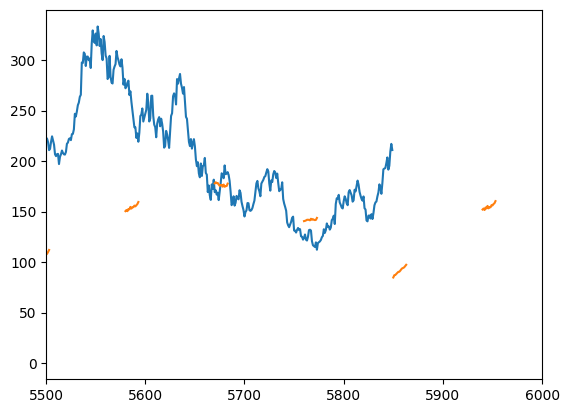

In [15]:
plt.plot(actual)
plt.plot(predictions)
plt.xlim(5500,6000)
plt.ylim()